# Toxic Comment Classification Challenge
Identify and classify toxic online comments

# Classifying multi-label comments with Logistic Regression

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## Load training and test data

In [2]:
path = r'C:\Users\user\Desktop\학교\학회\21-1\kaggle4'
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Examine the data (EDA)

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
105644,3546938b74dd3ed9,What's your problem? \n\nI've already explaine...,0,0,0,0,0,0
61348,a4388cfd8a9d3694,Axioamnesia has been blocked because of their ...,0,0,0,0,0,0
34340,5bb8a7b2f2ed7a11,Pagan Christ \n\nI'd like to propose a section...,0,0,0,0,0,0
11591,1ea6f295b53721b6,Protection removal\nAs i said here: https://en...,0,0,0,0,0,0
155772,c3636d932db6cfb9,"Comment Up until 2013, was a disambiguation p...",0,0,0,0,0,0


이때 comments는 toxic, severe toxic, obscene, threat, insult and identity hate 6가지 카테고리로 라벨링됨. 이중 라벨 분류 문제가 생김.

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [5]:
# 숫자형 컬럼에서의 missing value 확인
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


missing value는 없음. 평균값이 대부분 매우 작으므로 (0.05 이하) 긍정(1)으로 라벨되지 않은 사람이 많다는 의미.

In [6]:
# unlabelled 비율 확인
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


unlabelled 비율은 89.83%

In [7]:
# comment가 null인 갯수 확인
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
no_comment = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

train, test data의 comment는 모두 값을 가지므로 null 처리 필요 없음.

In [10]:
# train, test data의 전체 row 갯수와 각 카테고리별 수 확인
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in test is {}'.format(len(test_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in test is 153164
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [37]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


위에서도 언급했듯이 라벨링 되지 않은 데이터가 대부분임.

In [11]:
# train data의 comment_text 길이를 'char_length'에 저장
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

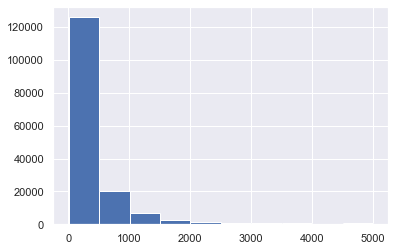

In [12]:
# text 길이를 hist plot으로 시각화
sns.set()
train_df['char_length'].hist()
plt.show()

대부분의 text가 500. 몇몇의 text는 5000 글자까지도 됨.

target 변수 사이의 corr을 확인.

In [13]:
data = train_df[cols_target]

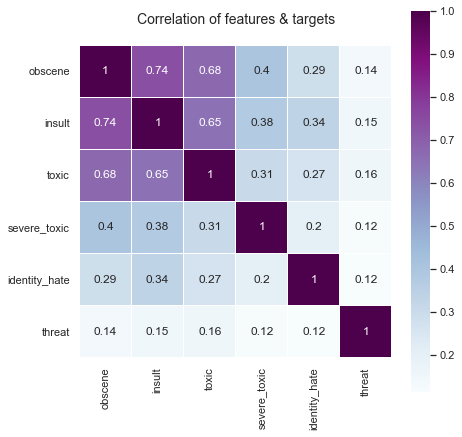

In [14]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(), linewidth=0.1, vmax=1.0, square=True, cmap='BuPu', linecolor='white', annot=True)

corr 결과
- insult(모욕)-obscene(역겨운): 0.74
- toxic-obscene: 0.68
- toxic-insult: 0.65

이번엔 test data에 대해서도 진행.

In [15]:
# train data의 comment_text 길이를 'char_length'에 저장
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

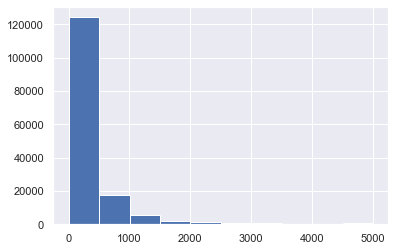

In [16]:
# text 길이를 hist plot으로 시각화
sns.set()
test_df['char_length'].hist()
plt.show()

train과 test의 char length 분포가 유사함. 훈련 데이터의 경우 라벨링된 사람들을 용이하게 하기 위해 5000자에서 잘린것으로 추측...?

## Clean up the comment text

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
# train, test data에 있는 comment_text를 clean
train_df['comment_text'] = train_df['comment_text'].map(lambda com: clean_text(com))
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

- map(함수, 리스트): 리스트로부터 원소를 하나씩 꺼내서 함수를 적용시킨 다음, 그 결과를 새로운 리스트에 담아줌.
- re.sub(정규 표현식, 대상 문자열 , 치환 문자): 
    - 정규 표현식: 검색 패턴을 지정
    - 대상 문자열: 검색 대상이 되는 문자열
    - 치환 문자: 변경하고 싶은 문자

## Define X from entire train & test data for use in tokenization by Vectorizer

In [19]:
train_df = train_df.drop('char_length', axis=1)

In [20]:
X = train_df.comment_text
test_X = test_df.comment_text

In [21]:
print(X.shape, test_X.shape)

(159571,) (153164,)


## Vectorize the data

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [23]:
# train data에서 voca를 학습한 후 document-term 행렬을 생성
X_dtm = vect.fit_transform(X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178715 stored elements in Compressed Sparse Row format>

In [24]:
# test data에서 이전에 fit된 voca를 학습한 후 document-term 행렬을 생성
test_X_dtm = vect.fit_transform(test_X)
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2624504 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem

- Binary Relevance: 가장 간단하게 single classification 문제로 분리할 수 있는 방법
- Classifier Chains
- Label Powerset: 이 경우 6개의 라벨이 있으므로 2^6 즉 64가지 문제..

### 1. Binary Relevance - build a multi-label classifier using Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

submission_binary = pd.read_csv('sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    
    # X_dtm, y를 이용해 모델 훈련
    logreg.fit(X_dtm, y)
    
    # train accuracy 계산
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # X_test_dtm의 pred prob. 계산
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob  

... Processing obscene


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9832363023356374
... Processing insult


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9755469352200588
... Processing toxic


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9639408163137412
... Processing severe_toxic


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9921100951927355
... Processing identity_hate


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9939713356436947
... Processing threat
Training accuracy is 0.9981199591404453


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.000794,0.002610,0.002303,0.000337,0.001843,0.000361
1,0000247867823ef7,0.041618,0.001201,0.002176,0.000355,0.019013,0.004469
2,00013b17ad220c46,0.422213,0.000461,0.032379,0.000323,0.004830,0.090157
3,00017563c3f7919a,0.034962,0.004503,0.078053,0.017294,0.036540,0.004662
4,00017695ad8997eb,0.224524,0.005122,0.035651,0.000433,0.019210,0.003462


submission_binary.to_csv('submission_binary.csv',index=False)

### 2. Classifier Chains - build a multi-label classifier using Logistic Regression

In [30]:
submission_chains = pd.read_csv('sample_submission.csv')

# add features 함수 생성
def add_feature(X, feature_to_add):
    
    # 더해진 feature를 포함한 희소 피처 matrix를 return
    
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [31]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    
    # X_dtm, y를 이용해 모델 훈련
    logreg.fit(X_dtm, y)
    
    # train accuracy 계산
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # test_X로 부터 prediction 생성
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    
    # 현재 label로부터 X_dtm으로 chain
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    
    # 현재 label predictions로부터 test_X_dtm으로 chain
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9832363023356374
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9817510700565892
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9675818287784121
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9929686471852655
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9955192359513947
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9985649021438733
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


In [32]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.000788,2.346625e-09,0.002303,0.000127,0.001200,0.000080
1,0000247867823ef7,0.042617,3.492947e-10,0.002176,0.000049,0.021170,0.000128
2,00013b17ad220c46,0.431961,1.848936e-10,0.032379,0.000062,0.000773,0.009635
3,00017563c3f7919a,0.029731,6.936281e-10,0.078053,0.002000,0.030610,0.000263
4,00017695ad8997eb,0.176950,8.532403e-10,0.035651,0.000064,0.003031,0.000325


submission_chains.to_csv('submission_chains.csv', index=False)

In [33]:
# combined submission 생성
submission_combined = pd.read_csv('sample_submission.csv')

In [34]:
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [35]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.000791,0.001305,0.002303,0.000232,0.001521,0.000220
1,0000247867823ef7,0.042117,0.000600,0.002176,0.000202,0.020092,0.002298
2,00013b17ad220c46,0.427087,0.000231,0.032379,0.000192,0.002801,0.049896
3,00017563c3f7919a,0.032347,0.002251,0.078053,0.009647,0.033575,0.002463
4,00017695ad8997eb,0.200737,0.002561,0.035651,0.000248,0.011121,0.001893
